In [33]:
%load_ext autoreload
%autoreload 2

import os
import sys
import tqdm

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import ml_collections
from ml_collections import config_dict

from models import noise_schedules
from models import transformer, scores, vdm
from models import diffusion_utils

import utils as ut

%matplotlib inline
plt.style.use('/mnt/home/tnguyen/default.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
# read the dataset
datadir = '/mnt/ceph/users/tnguyen/dark_camels/point-cloud-diffusion-datasets/processed_datasets/final-WDM-datasets'
data = np.load(os.path.join(datadir, 'galprop.npz'))
cond_table = pd.read_csv(os.path.join(datadir, 'galprop_cond.csv'))

conditioning_parameters = [
    "halo_mvir", "halo_mstar", "center_subhalo_mvir", "center_subhalo_mstar",
    "center_subhalo_vpeculiar", "center_subhalo_vmax_tilde", "log_num_subhalos",
    "inv_wdm_mass", "log_sn1", "log_sn2", "log_agn1"
]

# load the model
checkpoint = 'trained_models/test1/lightning_logs/version_2/checkpoints/epoch=5277-step=36946.ckpt'
model = vdm.VariationalDiffusionModel.load_from_checkpoint(checkpoint)

In [88]:
EPS = 1e-6

# preprocess the data
x = data['features']
mask = data['mask']
cond = cond_table[conditioning_parameters].values

# normalize the data and condition
x_mean = model.norm_dict['x_mean']
x_std = model.norm_dict['x_std']
cond_mean = model.norm_dict['cond_mean']
cond_std = model.norm_dict['cond_std']
x = (x - x_mean + EPS) / (x_std + EPS)
cond = (cond - cond_mean + EPS) / (cond_std + EPS)

x = torch.tensor(x, dtype=torch.float32)
cond = torch.tensor(cond, dtype=torch.float32)
# invert mask due to torch convention vs jax
mask = ~torch.tensor(mask, dtype=torch.bool)

In [89]:
def sample_step(model, z_t, i, T, conditioning=None, mask=None):
    eps = torch.randn_like(z_t)
    t = (T - i) / T
    s = (T - i - 1) / T
    g_t = model.gamma(t)
    g_s = model.gamma(s)
    cond = model.embed(conditioning)
    eps_hat_cond = model.score_model(
        z_t,
        g_t * torch.ones(z_t.shape[0], dtype=z_t.dtype, device=z_t.device),
        cond,
        mask
    )
    a = F.sigmoid(g_s)
    b = F.sigmoid(g_t)
    c = -torch.expm1(g_t - g_s)
    sigma_t = torch.sqrt(diffusion_utils.sigma2(g_t))
    z_s = (
        torch.sqrt(a / b) * (z_t - sigma_t * c * eps_hat_cond)
        + torch.sqrt((1.0 - a) * c) * eps
    )
    return z_s

In [90]:
batch_size = 128
n_sampling_steps = 1000
n_repeats = 1
dset = TensorDataset(x, cond, mask)
data_loader = DataLoader(dset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    model.eval()
    gen_samples = []
    gen_cond = []
    gen_mask = []
    for i in range(n_repeats):
        for batch in tqdm.tqdm(data_loader):
            x_batch, cond_batch, mask_batch = batch
            x_batch = x_batch.to(model.device)
            cond_batch = cond_batch.to(model.device)
            mask_batch = mask_batch.to(model.device)

            z_t = torch.randn_like(x_batch)
            for i in torch.arange(0, n_sampling_steps):
                z_t = sample_step(model, z_t, i, n_sampling_steps, cond_batch, mask_batch)
            g0 = model.gamma(0.0)
            var0 = diffusion_utils.sigma2(g0)
            z_0_rescaled = z_t / torch.sqrt(1.0 - var0)

            gen_batch = model.decode(z_0_rescaled).loc
            gen_samples.append(gen_batch.cpu().numpy())
            gen_cond.append(cond_batch.cpu().numpy())
            gen_mask.append(mask_batch.cpu().numpy())

gen_samples = np.concatenate(gen_samples, axis=0)
gen_cond = np.concatenate(gen_cond, axis=0)
gen_mask = np.concatenate(gen_mask, axis=0)

gen_samples = gen_samples * model.norm_dict['x_std'] + model.norm_dict['x_mean']
gen_cond = gen_cond * model.norm_dict['cond_std'] + model.norm_dict['cond_mean']
gen_mask = ~gen_mask

gen_samples = np.where(gen_mask[..., None], gen_samples, np.nan)

  0%|          | 0/8 [00:00<?, ?it/s]/mnt/home/tnguyen/miniconda3/envs/geometric/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
100%|██████████| 8/8 [00:43<00:00,  5.50s/it]


In [91]:
sim_samples = x.cpu().numpy() * model.norm_dict['x_std'] + model.norm_dict['x_mean']
sim_cond = gen_cond
sim_mask = gen_mask
sim_samples = np.where(sim_mask[..., None], sim_samples, np.nan)

In [92]:
# bin the data by the number of conditional parameters
n_bins_per_dim = 4
num_samples = gen_samples.shape[0]
num_cond = gen_cond.shape[1]
n_bins = n_bins_per_dim**num_cond
bin_edges = []
for i in range(num_cond):
    bin_vals = np.array_split(np.sort(gen_cond[..., i]), n_bins_per_dim)
    cond_min = np.array([np.min(vals) for vals in bin_vals])
    cond_max = np.array([np.max(vals) for vals in bin_vals])
    bin_edges.append(np.append(cond_min, cond_max[-1]))

# get the bin indices along each dimension
indices = [np.digitize(gen_cond[:, i], bin_edges[i]) - 1 for i in range(num_cond)]
sim_indices = [np.digitize(sim_cond[:, i], bin_edges[i]) - 1 for i in range(num_cond)]

In [93]:
min_bins = 0
index_conds = [7, 8, 9, 10]
labels = [
    "inv_wdm_mass", 
    "log_sn1", 
    "log_sn2", 
    "log_agn1"
]
labels_fancy = [
    r"$m_\mathrm{{WDM}} \in [{:.2f}, {:.2f}] \; \mathrm{{keV}}$",
    r"$e_w \in [{:.2f}, {:.2f}]$",
    r"$\kappa_w \in [{:.2f}, {:.2f}]$",
    r"$\epsilon_{{f, \mathrm{{high}}}} \in [{:.2f}, {:.2f}]$",
]
labels_cbar = [
    r'$m_\mathrm{wdm} \, [\rm keV]$',
    r'$e_w$',
    r'$\kappa_w$',
    r'$\epsilon_{f, \mathrm{high}}$',
    
]
gen_samples_bins = [[] for _ in index_conds]
gen_mask_bins = [[] for _ in index_conds]
gen_cond_bins = [[] for _ in index_conds]
sim_samples_bins = [[] for _ in index_conds]
sim_mask_bins = [[] for _ in index_conds]
sim_cond_bins = [[] for _ in index_conds]

for i_cond, index_cond, in enumerate(index_conds):
    # print(i_cond)
    for i in range(n_bins_per_dim):
        select = [None] * num_cond
        select[index_cond] = i
        bin_mask = ut.get_bins(indices, select)
        sim_bin_mask = ut.get_bins(sim_indices, select)

        if np.sum(bin_mask) < min_bins:
            continue
        # print(np.sum(bin_mask))
        
        gen_samples_bins[i_cond].append(gen_samples[bin_mask])
        gen_mask_bins[i_cond].append(gen_mask[bin_mask])
        gen_cond_bins[i_cond].append(gen_cond[bin_mask])
        sim_samples_bins[i_cond].append(sim_samples[sim_bin_mask])
        sim_mask_bins[i_cond].append(sim_mask[sim_bin_mask])
        sim_cond_bins[i_cond].append(sim_cond[sim_bin_mask])

In [94]:
# bin settings
x_bin_size = 0.25
x_plot_range = (5, 11) 
x_q = [50, 16, 84]
x_bins = np.arange(x_plot_range[0], x_plot_range[1] + x_bin_size, x_bin_size)
x_bins_center = 0.5 * (x_bins[:-1] + x_bins[1:])
x_num_bins = len(x_bins) - 1

In [95]:
def get_hist_stats(samples, bins, cumulative=False, normalized=False):
    """ Compute the qth percentile of a samples of histograms. """
    c = [np.histogram(samples[i], bins=bins)[0] for i in range(samples.shape[0])]
    c = np.stack(c, axis=0)
    if normalized:
        c = c / c.sum(1, keepdims=True)
    if cumulative:
        c = c.sum(1, keepdims=True) - np.cumsum(c, axis=1)
    c_mean = np.nanmean(c, axis=0)
    c_stdv = np.nanstd(c, axis=0)
    return c_mean, c_stdv

In [99]:
sim_mf = [[] for _ in index_conds]
sim_mf_norm = [[] for _ in index_conds]
for i in range(len(index_conds)):
    for j in range(n_bins_per_dim):
        log_mstar = sim_samples_bins[i][j][..., 7]
        gmf_q = get_hist_stats(log_mstar, x_bins, cumulative=True)
        sim_mf[i].append(gmf_q)
        gmf_q_norm = get_hist_stats(log_mstar, x_bins, cumulative=True, normalized=True)
        sim_mf_norm[i].append(gmf_q_norm)

gen_mf = [[] for _ in index_conds]
gen_mf_norm = [[] for _ in index_conds]
for i in range(len(index_conds)):
    print(i)
    for j in range(n_bins_per_dim):
        log_mstar = gen_samples_bins[i][j][..., 7]
        gmf_q = get_hist_stats(log_mstar, x_bins, cumulative=True)
        gen_mf[i].append(gmf_q)
        gmf_q_norm = get_hist_stats(log_mstar, x_bins, cumulative=True, normalized=True)
        gen_mf_norm[i].append(gmf_q_norm)

0
1
2
3


In [100]:
# universal plot settings
n_cols = len(index_conds)
n_rows = 3
figure_dpi = 200
panel_size_col = 5
panel_size_row = 5
xy_label_size = 24
legend_size = 16
markersize = 6
markersize_tng = 6
cmap = 'plasma'
colors = sns.color_palette('plasma', n_bins_per_dim)
xlim = [5.25, 9.25]
# xlim = [8, 10.5]
ylim = [5e-1, 25]
ylim_res = [-0.35, 0.35]
height_ratios = [3, 1, 1]
xticks = np.arange(5, 12, 1)
hspace = 0
wspace = 0
figsize = (
    n_cols * panel_size_col, 
    panel_size_row / height_ratios[0] * np.sum(height_ratios)
)

/tmp/ipykernel_780915/3590203919.py:28: RuntimeWarning: invalid value encountered in divide
  res = (gen_x_med - sim_x_med) / sim_x_med
/tmp/ipykernel_780915/3590203919.py:30: RuntimeWarning: invalid value encountered in divide
  res_stderr = sim_x_stderr / sim_x_med**2 * gen_x_med
/tmp/ipykernel_780915/3590203919.py:28: RuntimeWarning: divide by zero encountered in divide
  res = (gen_x_med - sim_x_med) / sim_x_med


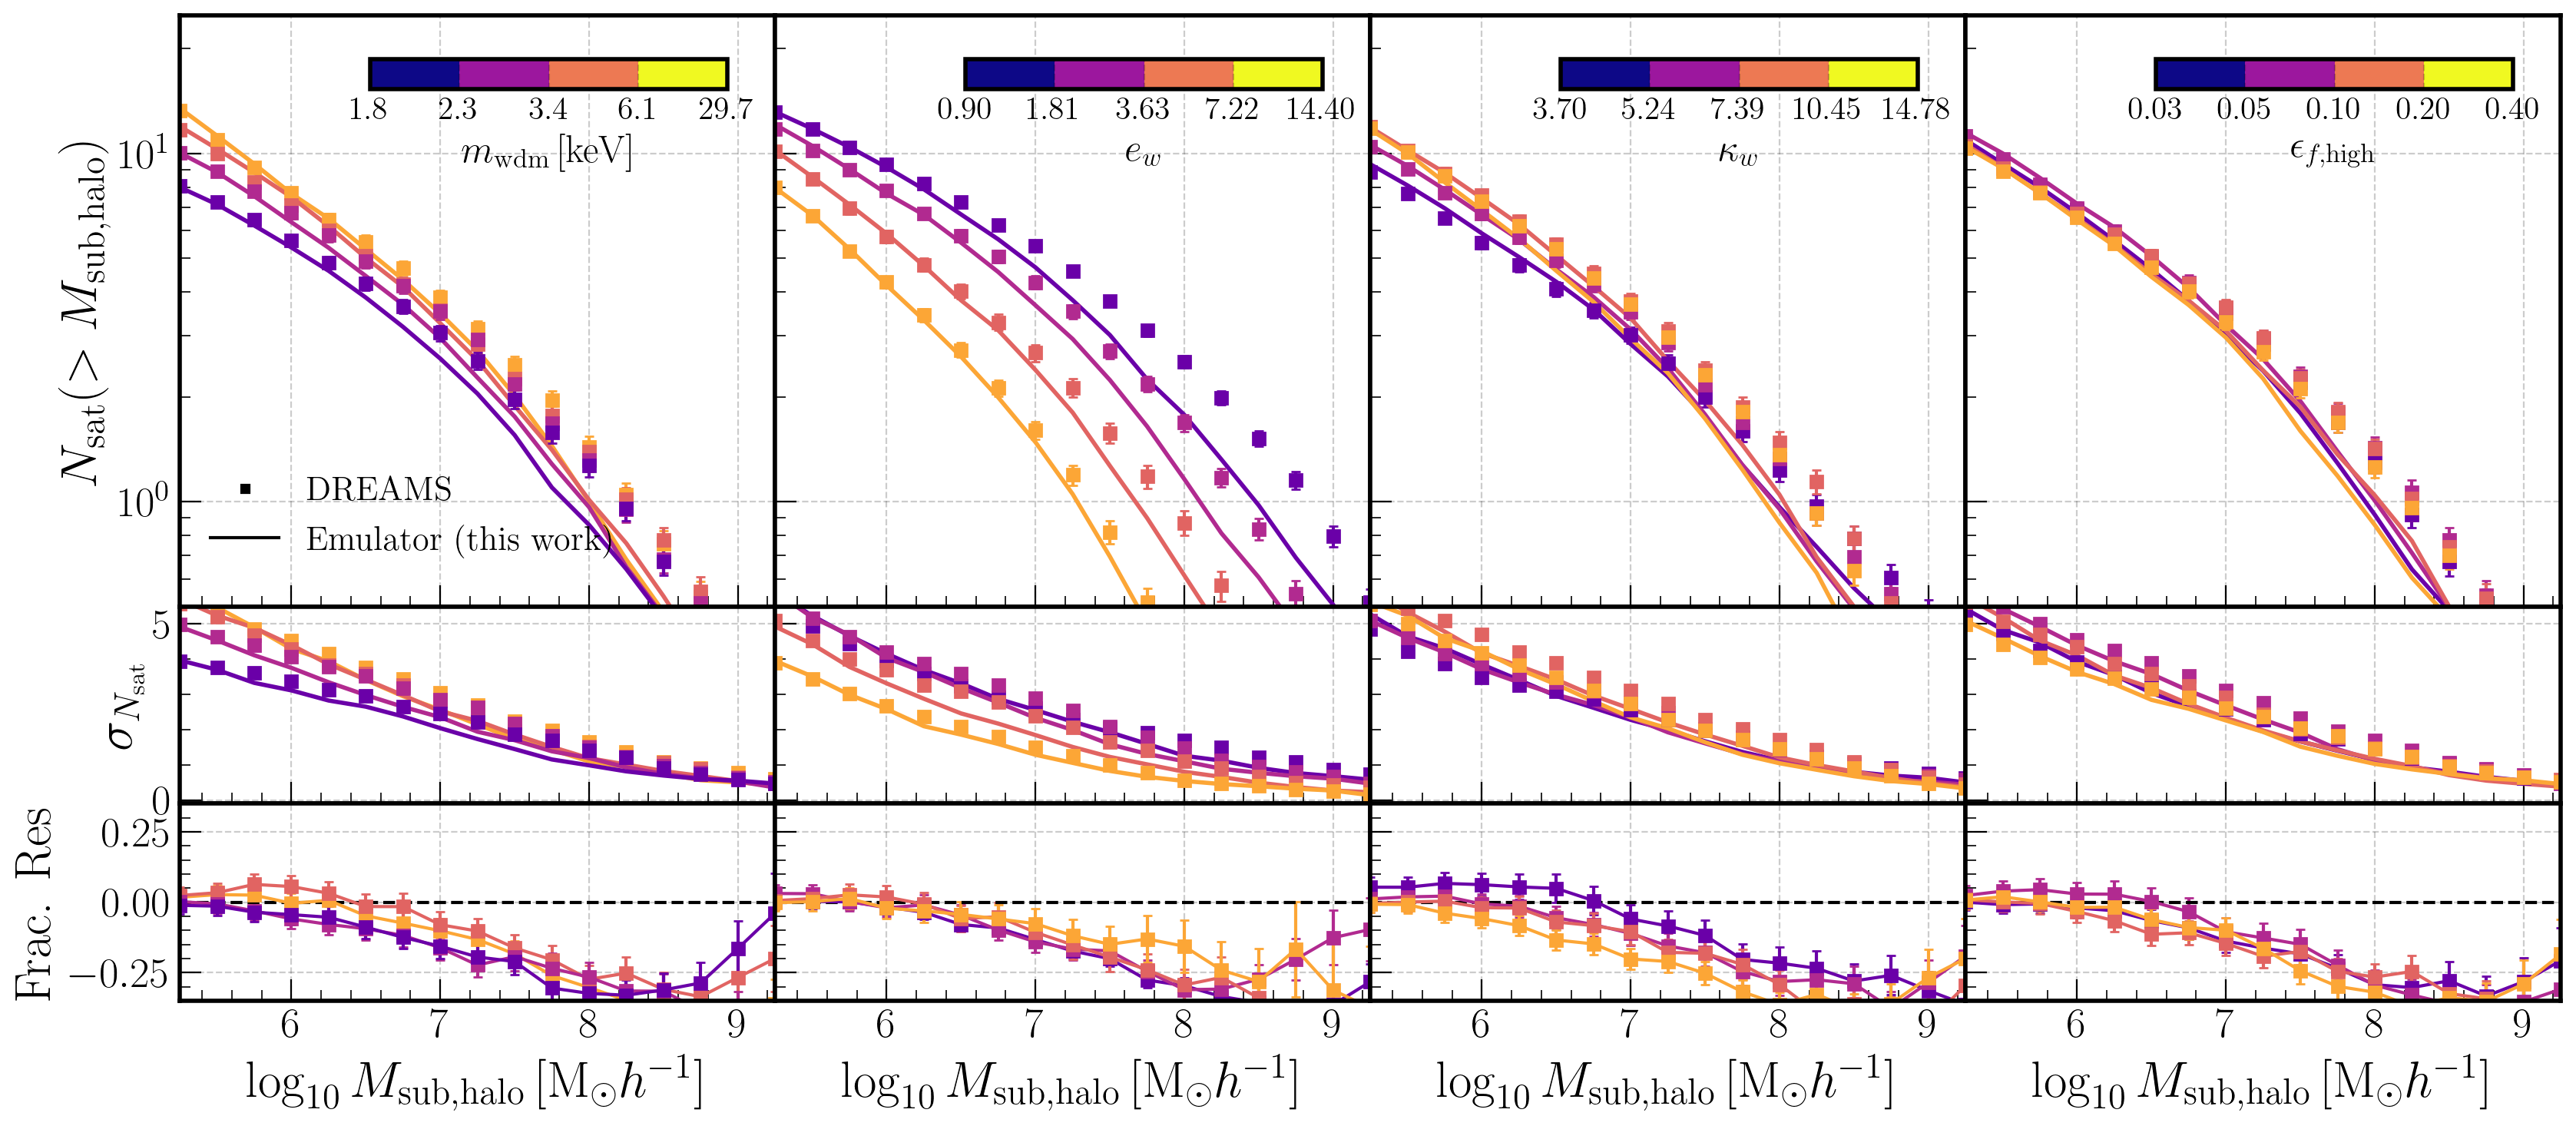

In [101]:
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=figsize, sharex=True, sharey='row', 
    gridspec_kw=dict(height_ratios=height_ratios), dpi=figure_dpi)

for i in range(n_cols):
    for j in range(n_bins_per_dim):
        cond_min = bin_edges[index_conds[i]][j]
        cond_max = bin_edges[index_conds[i]][j+1]
        if labels[i] == 'inv_wdm_mass':
            cond_min, cond_max = 1/cond_max, 1/cond_min
            color = colors[::-1][j]
        elif labels[i] == 'halo_mvir':
            color = colors[j]
        else:
            cond_min, cond_max = 10**cond_min, 10**cond_max
            color = colors[j]
        label = labels_fancy[i].format(cond_min, cond_max)
        
        # compute and plot the mass functions
        num_gen = len(gen_samples_bins[i][j])
        num_sim = len(sim_samples_bins[i][j])

        # calculate the median and 1-sigma error bars
        gen_x_med, gen_x_stdv = gen_mf[i][j]
        sim_x_med, sim_x_stdv = sim_mf[i][j]
        gen_x_stderr = gen_x_stdv / np.sqrt(num_gen)
        sim_x_stderr = sim_x_stdv / np.sqrt(num_sim)
        res = (gen_x_med - sim_x_med) / sim_x_med
        res = np.where(sim_x_med > 0, res, np.nan)
        res_stderr = sim_x_stderr / sim_x_med**2 * gen_x_med

        axes[0, i].plot(
            x_bins[:-1], gen_x_med, lw=2, color=color, label=label)
        axes[0, i].errorbar(
            x_bins[:-1], sim_x_med, yerr=sim_x_stderr, markersize=markersize,
            fmt='s', color=color, capsize=2, capthick=1)
        axes[1, i].plot(
            x_bins[:-1], gen_x_stdv, lw=2, color=color)

        axes[1, i].errorbar(
            x_bins[:-1], sim_x_stdv, markersize=markersize,
            fmt='s', color=color, capsize=2, capthick=1)
        axes[2, i].errorbar(
            x_bins[:-1], res, yerr=res_stderr, markersize=markersize,
            fmt='s', color=color, capsize=2, capthick=1, ls='-')

# plot zero lines
for i in range(n_cols):
    axes[2, i].axhline(0, color='k', ls='--')

# format axis limits
axes[0, 0].set_yscale('log')
axes[2, 0].set_xticks(xticks)
axes[0, 0].set_ylim(*ylim)
axes[1, 0].set_ylim(*ylim_stdv)
axes[2, 0].set_ylim(*ylim_res)
axes[0, 0].set_xlim(*xlim)

# format axis labels
for i in range(n_cols):
    axes[-1, i].set_xlabel(
        r'$\log_{10} M_\mathrm{sub, halo} \, [\mathrm{M}_\odot h^{-1}]$', 
        fontsize=xy_label_size)
axes[0, 0].set_ylabel(r'$N_\mathrm{sat}(> M_\mathrm{sub, halo})$', fontsize=xy_label_size)
axes[1, 0].set_ylabel(r'$\sigma_{N_\mathrm{sat}}$', fontsize=xy_label_size)
axes[2, 0].set_ylabel(r'Frac. Res', fontsize=xy_label_size)

# create the colorbar axes
for i in range(n_cols):
    cmap_arr = plt.get_cmap(cmap, n_bins_per_dim)  # Get the colormap
    bounds = np.linspace(0, 100, n_bins_per_dim + 1)  # Define the boundaries of the bins
    norm = mpl.colors.BoundaryNorm(bounds, cmap_arr.N)

    # create inset axes for colorbar
    cbar_ax = inset_axes(
        axes[0, i],
        width="60%",  
        height="5%",  
        loc="center",
        bbox_to_anchor=(0.12, 0.4, 1, 1),
        bbox_transform=axes[0, i].transAxes,
    )
    cbar_ax.xaxis.set_ticks_position("bottom")
    sm = plt.cm.ScalarMappable(cmap=cmap_arr, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(
        sm, cax=cbar_ax, orientation='horizontal') 
    cbar.set_label(labels_cbar[i], fontsize=18)

    if labels[i] == 'inv_wdm_mass':
        tick_labels = ['{:.1f}'.format(1/x) for x in bin_edges[index_conds[i]]]
        tick_labels = tick_labels[::-1]
    else:
        tick_labels = ['{:.2f}'.format(10**x) for x in bin_edges[index_conds[i]]]
    cbar.set_ticklabels(tick_labels, fontsize=15)
    cbar_ax.tick_params(axis='x', length=0)

# create legend for sim, gen and TNG
handles = [
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='k', markersize=markersize, ls=''),
    plt.Line2D([0], [0], ls='-', color='k'),
    # plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='k', markersize=markersize_tng, ls='dotted'),
]
hlabels = ['DREAMS', 'Emulator (this work)',]
axes[0, 0].legend(
    handles, hlabels, loc='lower left', fontsize=legend_size, frameon=False, 
    bbox_transform=axes[0, 0].transAxes, bbox_to_anchor=(0.00, 0.03))

fig.subplots_adjust(hspace=hspace, wspace=wspace)